In [1]:
import os
import glob
from functools import reduce

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

# display plots in the notebook
%matplotlib inline

# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

/opt/conda/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
results_dir = "../../results/"
base_dir = "timeseries/time-scales/"
arrival_rates = [
    "1_X_max",
    "2_X_max",
    "3_X_max"
]
run_type = "single-backend"
fluctuation_timeperiod = "500ms-fluctuation"
run_time = "3mins-run"
feedback_intervals = ["1ms-feedback", "5ms-feedback", "20ms-feedback", "200ms-feedback", "600ms-feedback", 
                      "1000ms-feedback", "5000ms-feedback"]
algos = ["wlc", 
         "feedback-wlc"]
runs = ["1111-seed", "2222-seed", "3333-seed"]

## Preprocess Data

In [4]:
rr_percentiles = ['Request rate', 'Response rate 50%', 'Response rate 66%', 'Response rate 75%',
                  'Response rate 80%', 'Response rate 90%', 'Response rate 95%', 'Response rate 98%',
                  'Response rate 99%', 'Response rate 100%'] 

In [5]:
rt_percentiles = ['Response time', 'Response time 50%', 'Response time 66%', 'Response time 75%',
                  'Response time 80%', 'Response time 90%', 'Response time 95%', 'Response time 98%',
                  'Response time 99%', 'Response time 100%']

In [6]:
def preprocess_data(d):
    plot_data_list = []
    for i in glob.glob(d + "/httperf_client_*.csv"):
        plot_data_list.append(pd.read_csv(i, header=0, na_filter=False))

    plot_data = pd.DataFrame()

    if len(plot_data_list) > 0:
        for i in list(plot_data_list[0]):
            if not i.startswith('Response time'):
                plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] for j in range(len(plot_data_list))])
            else:
                plot_data[i] = reduce(lambda x, y: x + y, [plot_data_list[j][i] 
                                                           for j in range(len(plot_data_list))]) / len(plot_data_list)
     
    rr_plot_data = plot_data[rr_percentiles]
    rr_plot_data.to_csv(d + "/response_rate.csv")
    rt_plot_data = plot_data[rt_percentiles]
    rt_plot_data.to_csv(d + "/response_time.csv")

In [7]:
for i in glob.glob(results_dir + base_dir + "*/" + run_type + "/" +  fluctuation_timeperiod + "/" + 
                   run_time + "/*/*/*/run"):
    preprocess_data(i)

## Response time

In [8]:
rt_plot_data_dict = {}

for i in glob.glob(results_dir + base_dir + "*/" + run_type + "/" +  fluctuation_timeperiod + "/" + 
                   run_time + "/*/*/*/run/" + "response_time.csv"):
    for arrival_rate in arrival_rates:
        if ("/"+arrival_rate+"/") in i:
            for feedback_interval in feedback_intervals:
                if ("/"+feedback_interval+"/") in i:
                    for algo in algos:
                        if ("/"+algo+"/") in i:
                            for run in runs:
                                if run in i:
                                    rt_plot_data_dict[arrival_rate+":"+feedback_interval+":"+algo+":"+run] = pd.read_csv(i, header=0, na_filter=False)

In [9]:
rt_plot_data = pd.DataFrame()
rt_plot_data['percentiles'] = rt_percentiles

rt_plot_percentile_dict = {}
for i in rt_percentiles:
    for k in rt_plot_data_dict:
        if k in rt_plot_percentile_dict:
            rt_plot_percentile_dict[k].append(rt_plot_data_dict[k][i][0])
        else:
            rt_plot_percentile_dict[k] = []
            rt_plot_percentile_dict[k].append(rt_plot_data_dict[k][i][0])
            
for k in rt_plot_data_dict:
    rt_plot_data[k] = rt_plot_percentile_dict[k]
    
rt_plot_data.columns.values

array(['percentiles', '3_X_max:200ms-feedback:feedback-wlc:1111-seed',
       '1_X_max:1000ms-feedback:feedback-wlc:3333-seed',
       '2_X_max:20ms-feedback:wlc:1111-seed',
       '1_X_max:5ms-feedback:feedback-wlc:2222-seed',
       '3_X_max:600ms-feedback:feedback-wlc:3333-seed',
       '3_X_max:1ms-feedback:feedback-wlc:3333-seed',
       '1_X_max:5000ms-feedback:feedback-wlc:2222-seed',
       '2_X_max:5000ms-feedback:feedback-wlc:3333-seed',
       '3_X_max:5000ms-feedback:feedback-wlc:3333-seed',
       '2_X_max:20ms-feedback:feedback-wlc:2222-seed',
       '2_X_max:5000ms-feedback:feedback-wlc:1111-seed',
       '1_X_max:600ms-feedback:wlc:1111-seed',
       '2_X_max:1ms-feedback:feedback-wlc:3333-seed',
       '2_X_max:600ms-feedback:wlc:3333-seed',
       '1_X_max:1ms-feedback:wlc:1111-seed',
       '1_X_max:1ms-feedback:feedback-wlc:1111-seed',
       '1_X_max:600ms-feedback:wlc:3333-seed',
       '3_X_max:600ms-feedback:wlc:3333-seed',
       '2_X_max:20ms-feedback:feedback

### Percentiles ...

500ms fluctuation, 0.5 alpha, 0.005 state feedback, 0.001 stat collection.

In [10]:
err_dict = {}
for arrival_rate in arrival_rates:
    for feedback_interval in feedback_intervals:
        for algo in algos:
            err_dict[arrival_rate+":"+feedback_interval+":"+algo] = pd.DataFrame()

index = ['Avg.', '50%', '66%', '75%', '80%', '90%', '95%', '98%', '99%', '100%']        
means = pd.DataFrame()
means['percentiles'] = index
errs = pd.DataFrame()
errs['percentiles'] = index

means = means.set_index('percentiles')
errs = errs.set_index('percentiles')

for i in range(len(rt_percentiles)):
    for arrival_rate in arrival_rates:
        for feedback_interval in feedback_intervals:
            for algo in algos:
                err_list = []
                for run in runs:
                    err_list.append(rt_plot_data[arrival_rate+":"+feedback_interval+":"+algo+":"+run][i])
                err_dict[arrival_rate+":"+feedback_interval+":"+algo][rt_percentiles[i]] = err_list

for arrival_rate in arrival_rates:
    for feedback_interval in feedback_intervals:
        for algo in algos:
            means[arrival_rate+":"+feedback_interval+":"+algo] = list(err_dict[arrival_rate+":"+feedback_interval+":"+algo].mean())
            errs[arrival_rate+":"+feedback_interval+":"+algo] = list(err_dict[arrival_rate+":"+feedback_interval+":"+algo].std())

In [11]:
means.columns.values

array(['1_X_max:1ms-feedback:wlc', '1_X_max:1ms-feedback:feedback-wlc',
       '1_X_max:5ms-feedback:wlc', '1_X_max:5ms-feedback:feedback-wlc',
       '1_X_max:20ms-feedback:wlc', '1_X_max:20ms-feedback:feedback-wlc',
       '1_X_max:200ms-feedback:wlc', '1_X_max:200ms-feedback:feedback-wlc',
       '1_X_max:600ms-feedback:wlc', '1_X_max:600ms-feedback:feedback-wlc',
       '1_X_max:1000ms-feedback:wlc',
       '1_X_max:1000ms-feedback:feedback-wlc',
       '1_X_max:5000ms-feedback:wlc',
       '1_X_max:5000ms-feedback:feedback-wlc', '2_X_max:1ms-feedback:wlc',
       '2_X_max:1ms-feedback:feedback-wlc', '2_X_max:5ms-feedback:wlc',
       '2_X_max:5ms-feedback:feedback-wlc', '2_X_max:20ms-feedback:wlc',
       '2_X_max:20ms-feedback:feedback-wlc', '2_X_max:200ms-feedback:wlc',
       '2_X_max:200ms-feedback:feedback-wlc', '2_X_max:600ms-feedback:wlc',
       '2_X_max:600ms-feedback:feedback-wlc',
       '2_X_max:1000ms-feedback:wlc',
       '2_X_max:1000ms-feedback:feedback-wlc',
     

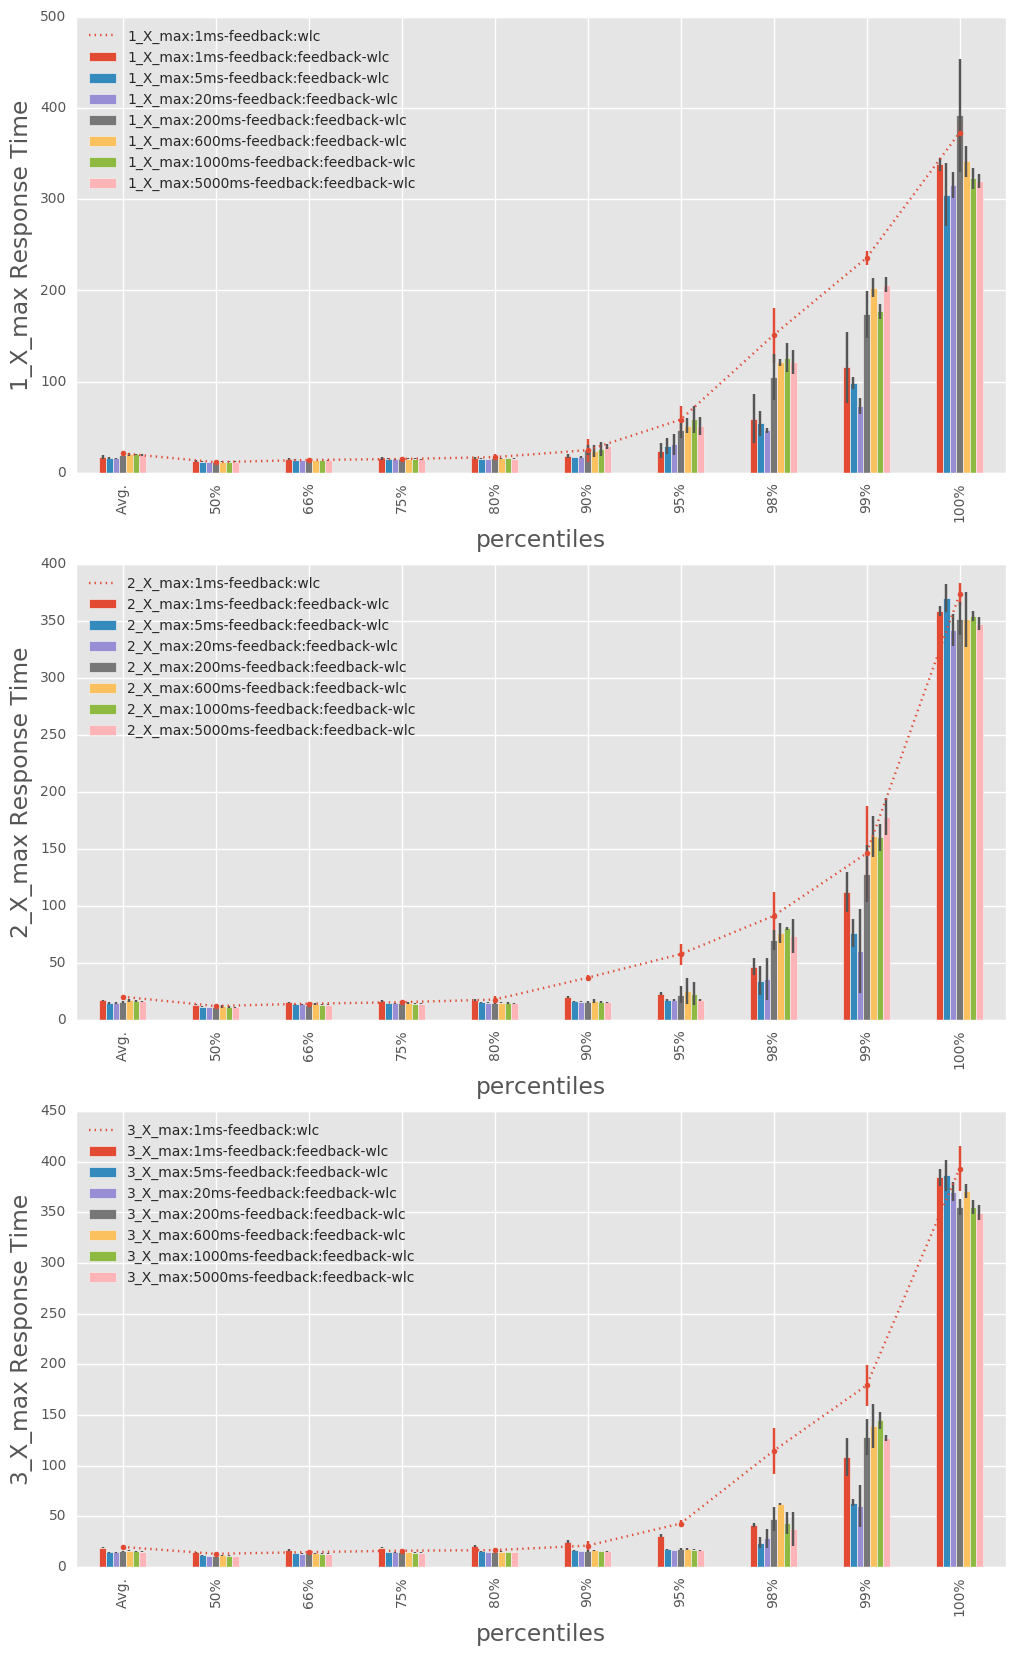

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=1)

for i in range(len(arrival_rates)):
    means[[arrival_rates[i]+":1ms-feedback:wlc"]].plot(kind='line', yerr=errs, figsize=(12,20), linestyle=":", marker='o', markersize=4, ax=ax[i])
    means[[arrival_rates[i]+":1ms-feedback:feedback-wlc",
           arrival_rates[i]+":5ms-feedback:feedback-wlc",
           arrival_rates[i]+":20ms-feedback:feedback-wlc",
           arrival_rates[i]+":200ms-feedback:feedback-wlc",
           arrival_rates[i]+":600ms-feedback:feedback-wlc",
           arrival_rates[i]+":1000ms-feedback:feedback-wlc",
           arrival_rates[i]+":5000ms-feedback:feedback-wlc"]].plot(kind='bar', yerr=errs, figsize=(12,20), ax=ax[i])
    ax[i].set_ylabel(arrival_rates[i]+' Response Time')

fig.savefig('time-scales-plots-with-wlc-trendline (all).pdf')

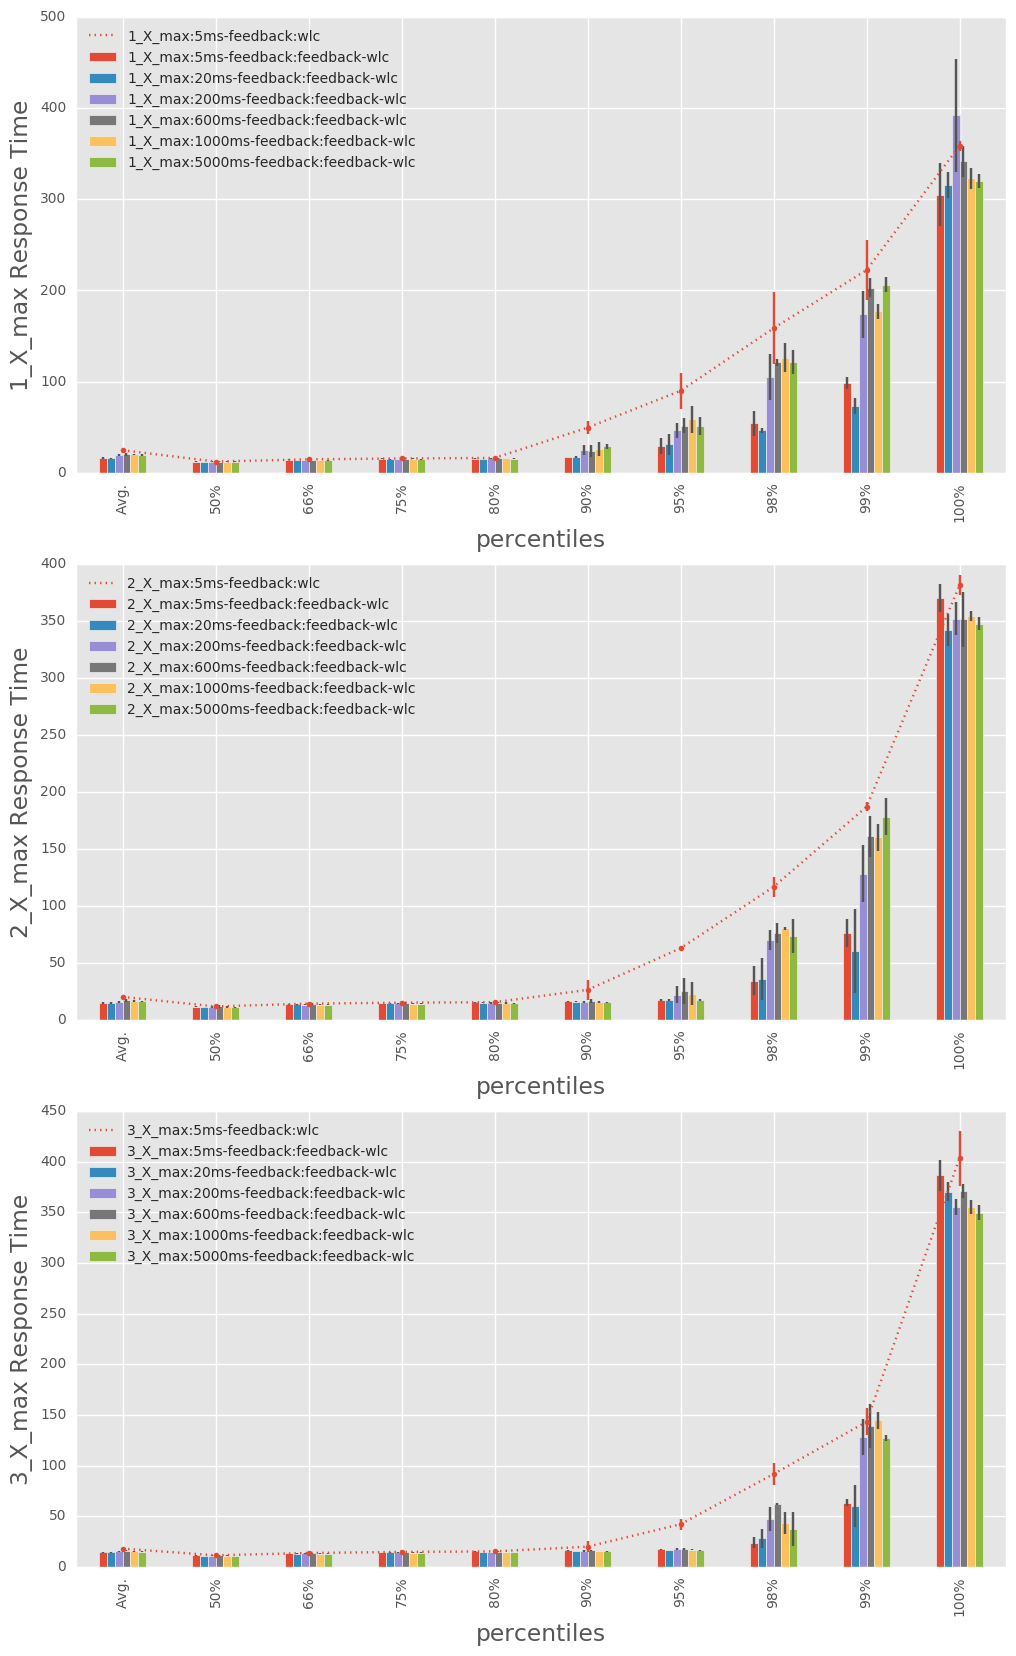

In [14]:
fig, ax = plt.subplots(nrows=3, ncols=1)

for i in range(len(arrival_rates)):
    means[[arrival_rates[i]+":5ms-feedback:wlc"]].plot(kind='line', yerr=errs, figsize=(12,20), linestyle=":", marker='o', markersize=4, ax=ax[i])
    means[[arrival_rates[i]+":5ms-feedback:feedback-wlc",
           arrival_rates[i]+":20ms-feedback:feedback-wlc",
           arrival_rates[i]+":200ms-feedback:feedback-wlc",
           arrival_rates[i]+":600ms-feedback:feedback-wlc",
           arrival_rates[i]+":1000ms-feedback:feedback-wlc",
           arrival_rates[i]+":5000ms-feedback:feedback-wlc"]].plot(kind='bar', yerr=errs, figsize=(12,20), ax=ax[i])
    ax[i].set_ylabel(arrival_rates[i]+' Response Time')

fig.savefig('time-scales-plots-with-wlc-trendline-without-1ms (all).pdf')

In [13]:
means.describe()

1_X_max:1ms-feedback:wlc  1_X_max:1ms-feedback:feedback-wlc  \
count                 10.000000                          10.000000   
mean                  92.140417                          63.194583   
std                  123.726937                         101.826742   
min                   11.625000                          12.833333   
25%                   15.583333                          15.927083   
50%                   22.972917                          17.556250   
75%                  127.770833                          50.541667   
max                  372.916667                         338.083333   

       1_X_max:5ms-feedback:wlc  1_X_max:5ms-feedback:feedback-wlc  \
count                 10.000000                          10.000000   
mean                  96.195833                          57.760417   
std                  116.686776                          91.004047   
min                   12.250000                          12.083333   
25%                   15.770833                          15.364583   
50%                   37.041667                          16.697917   
75%                  141.302083                          47.958333   
max                  358.583333                         305.000000   

       1_X_max:20ms-feedback:wlc  1_X_max:20ms-feedback:feedback-wlc  \
count                  10.000000                           10.000000   
mean                   94.056250                           55.429583   
std                   113.417510                           93.496898   
min                    12.125000                           11.625000   
25%                    16.541667                           14.822917   
50%                    35.760417                           16.272917   
75%                   133.687500                           42.750000   
max                   347.916667                          315.583333   

       1_X_max:200ms-feedback:wlc  1_X_max:200ms-feedback:feedback-wlc  \
count                   10.000000                            10.000000   
mean                   102.146667                            81.785000   
std                    121.396234                           120.989896   
min                     12.750000                            12.208333   
25%                     18.989583                            15.187500   
50%                     33.087500                            22.050000   
75%                    168.729167                            90.375000   
max                    355.958333                           391.791667   

       1_X_max:600ms-feedback:wlc  1_X_max:600ms-feedback:feedback-wlc  \
count                   10.000000                            10.000000   
mean                    95.118333                            81.769583   
std                    111.333103                           110.606805   
min                     12.291667                            12.166667   
25%                     15.718750                            15.218750   
50%                     41.737500                            21.931250   
75%                    140.552083                           103.531250   
max                    342.916667                           341.583333   

                       ...                   3_X_max:20ms-feedback:wlc  \
count                  ...                                   10.000000   
mean                   ...                                   78.260000   
std                    ...                                  118.391319   
min                    ...                                   11.791667   
25%                    ...                                   15.093750   
50%                    ...                                   19.820833   
75%                    ...                                   86.145833   
max                    ...                                  387.458333   

       3_X_max:20ms-feedback:feedback-wlc  3_X_max:200ms-feedback:wlc  \
count                 